In [1]:
%%capture cell_output

!pip install contractions

**1.0 Introduction**

This notebook uses LSTM and [GloVe twitter embedding](https://nlp.stanford.edu/projects/glove/) to classify a tweet if it relates to a real distaster or not. 

**2.0 Load data**
This section load training data, test data, and the Glove embeddings.

In [2]:
import os

#path to GloVe embeddings file
Glove_embeddings = '/kaggle/input/glovetwitter27b50dtxt/glove.twitter.27B.50d.txt'

In [3]:
import numpy as np

def load_pretrained_embedding(embedding_fpath):
    #loads embeddings from file e.g GloVe to a dict object
    with open(embedding_fpath, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            words.add(line[0])
            word_to_vec_map[line[0]] = np.array(line[1:], dtype=np.float64)
            
        print('GloVe embedding loaded')
        return word_to_vec_map

In [4]:
#load the Glove Embeddings
word_to_vec_map = load_pretrained_embedding(Glove_embeddings)

#list the first 10 keys of the embeddings
print(list(word_to_vec_map.keys())[:20])

GloVe embedding loaded
['<user>', '.', ':', 'rt', ',', '<repeat>', '<hashtag>', '<number>', '<url>', '!', 'i', 'a', '"', 'the', '?', 'you', 'to', '(', '<allcaps>', '<elong>']


In [5]:
import pandas as pd

input_dir = '/kaggle/input/nlp-getting-started'

#load the training data to data frame
train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
#load test data to data frame
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


**2.0 Exploratory Data analysis**

The training data frame has column. Plot of the distribution of the target variables in training set show that most of the tweet are not for a distaster (target=0).   

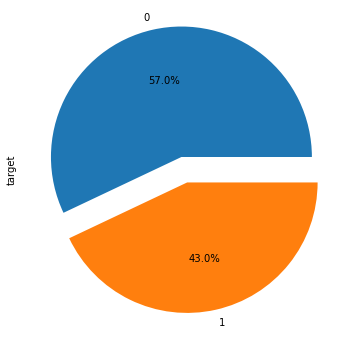

In [7]:
#plot the count 
#import seaborn as sns
import matplotlib.pyplot as plt

#sns.countplot(x = train_df['target'])
fig = plt.figure(figsize=(8,6))

train_df.groupby('target').target.count().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=False)

plt.show()

Below code print 5 random tweets from each category.

In [8]:
import random
from termcolor import colored #library for printing colored text
import textwrap

random.seed(123)

#get 3 image from each group
sample_tweets = train_df[['id', 'text','target']].groupby('target').sample(n=5) 

for index, row in sample_tweets.iterrows():
    print(colored('Tweet : ', 'red'), textwrap.fill(row['text'], 100))
    print(colored('Target : ', 'red'), row['target'])   


Tweet :  #NoSurrender Results: Full Metal Mayhem World Title Match Bully Ray Taken Out A Career Comes To An
End and More! http://t.co/XEHwmsH7Lv
Target :  0
Tweet :  Over half of poll respondents worry nuclear disaster fading from public consciousness
http://t.co/YtnnnD631z ##fukushima
Target :  0
Tweet :  Watch Sarah Palin OBLITERATE Planned Parenthood For Targeting Minority Women! ÛÒ BB4SP
http://t.co/fqMYprlG9g
Target :  0
Tweet :  Aftershock was the most terrifying best roller coaster I've ever been on. *DISCLAIMER* I've been on
very few.
Target :  0
Tweet :  Obliterated my phone screen today with a drum stick. #blessed
Target :  0
Tweet :  Science Daily: Lightning reshapes rocks at the atomic level - A lightning strike can reshape a
mineral's crystal s... http://t.co/TEZLTqeyw2
Target :  1
Tweet :  Physical sense helps preserve memories of 2011 triple disaster (8/4 AJW) http://t.co/X5jGKjV6Ma
#jishin_e #nuclear #Minamisoma
Target :  1
Tweet :  #360WiseNews : China's Stock Market 

**2.1 Prepare training data**

This section prepares the data to be feed in the model. To ensure that the model performance better, the training data is processed to remove tags and urls. Also word contractions were expanded in the processing tweet function. The tweets were also converted to lowercase. Below function processes the tweets.

In [9]:
from nltk.tokenize import TweetTokenizer
import re
import contractions

tw_tokenizer = TweetTokenizer()

def process_tweet(tweet):
    #function pre-processes the tweets by among other things convert tweets to lower case and tokenizes them
    
    tweet = tweet.lower() #convert to lower case
    tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)|(#[A-Za-z0-9]+)", " ", tweet).split())  # remove #tags and @usernames
    tweet = ' '.join(re.sub("(\w+:\/\/\S+)", " ", tweet).split()) # remove urls
    tweet = re.sub("[\.,]", "", tweet) # replace period and commas
    
    #replace all contractions to full words i.e. it's = it is; ain't = are not
    tweet = ' '.join([contractions.fix(word) for word in tweet.split()])
    
    return tw_tokenizer.tokenize(tweet)

In [10]:
p_tweets = []

#process the tweets
for tweet in train_df['text'].values:
    p_tweets.append(process_tweet(tweet))

#print first 5 processed tweets
print(p_tweets[:5])


[['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'may', 'allah', 'forgive', 'us', 'all'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'], ['all', 'residents', 'asked', 'to', "'", 'shelter', 'in', 'place', "'", 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected'], ['13000', 'people', 'receive', 'evacuation', 'orders', 'in', 'california'], ['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'as', 'smoke', 'from', 'pours', 'into', 'a', 'school']]


Below code uses Keras tokenizer to convert the tweeta into a sequence of integers.

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

MAX_NUM_WORDS = 10000

#get longest sequence
max_tweet_len = max(len(tw) for tw in p_tweets) + 1

kr_tokenizer = Tokenizer(oov_token='unk')

kr_tokenizer.fit_on_texts(p_tweets)
sequences = kr_tokenizer.texts_to_sequences(p_tweets)

word_index = kr_tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_data = pad_sequences(sequences, maxlen=max_tweet_len)

Y_labels = np.asarray(train_df['target'])
print(X_data.shape)
print(Y_labels.shape)

Found 14311 unique tokens.
(7613, 42)
(7613,)


**3.0 Build model**

Below code build RNN model that will use LSTM. Transfer learning will be used by the model by using the pre-trained weights from the GloVe twitter embedding.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, AveragePooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding

embedding_dim = word_to_vec_map["the"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
vocab_len = len(word_index) + 1  # adding 1 to fit Keras embedding (requirement)

model1 = Sequential()

#input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1
#input_length: Length of input sequences, when it is constant. 
#max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 

model1.add(Embedding(input_dim=vocab_len, output_dim=embedding_dim, input_length=max_tweet_len))
model1.add(LSTM(128, return_sequences=True)) #returned output is a batch of sequences.
model1.add(Dropout(0.2))
model1.add(LSTM(128, return_sequences=False))#returned output is not batch of sequences.
model1.add(Dropout(0.2))
model1.add(Dense(1, activation="sigmoid"))


Below function get the weights from GloVe embeddings.

In [13]:
def get_embedding_weights(word_to_vec_map, vocab_len, word_index):
    #function to get GloVe embedding weights
    emb_dim = word_to_vec_map["the"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros(shape=(vocab_len, emb_dim))
    
    unks = []
    unk_count = 0
    
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_index.items():
        emb = word_to_vec_map.get(word)
        if emb is not None:
            emb_matrix[idx] = emb
        else:
            emb_matrix[idx] = word_to_vec_map.get('unk') #get the 'unk' embedding from glove for OOV
            unk_count = unk_count + 1
            unks.append(word)
            
    return emb_matrix, unks

In [14]:
#get the embedding matrix weights
embedding_matrix_wgt, unks = get_embedding_weights(word_to_vec_map, vocab_len, word_index)

#assign pretrained embeddings to the embedding layer
model1.layers[0].set_weights([embedding_matrix_wgt])
model1.layers[0].trainable = False

print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 42, 50)            715600    
_________________________________________________________________
lstm (LSTM)                  (None, 42, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 42, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 938,961
Trainable params: 223,361
Non-trainable params: 715,600
____________________________________________

In [15]:
#compile model
model1.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
    
#train the model
history = model1.fit(X_data, Y_labels, validation_split = 0.2, 
                     epochs = 50, batch_size = 128, callbacks=[es],
                     shuffle=True)    

Epoch 1/50
48/48 [==============================] - 15s 237ms/step - loss: 0.5979 - accuracy: 0.6725 - val_loss: 0.4572 - val_accuracy: 0.7905
Epoch 2/50
48/48 [==============================] - 10s 205ms/step - loss: 0.4685 - accuracy: 0.7907 - val_loss: 0.4390 - val_accuracy: 0.7866
Epoch 3/50
48/48 [==============================] - 10s 204ms/step - loss: 0.4653 - accuracy: 0.7889 - val_loss: 0.4362 - val_accuracy: 0.7892
Epoch 4/50
48/48 [==============================] - 10s 202ms/step - loss: 0.4450 - accuracy: 0.8049 - val_loss: 0.4305 - val_accuracy: 0.8056
Epoch 5/50
48/48 [==============================] - 10s 205ms/step - loss: 0.4490 - accuracy: 0.8010 - val_loss: 0.4320 - val_accuracy: 0.7978
Epoch 6/50
48/48 [==============================] - 10s 207ms/step - loss: 0.4396 - accuracy: 0.8075 - val_loss: 0.4371 - val_accuracy: 0.7971
Epoch 7/50
48/48 [==============================] - 10s 207ms/step - loss: 0.4331 - accuracy: 0.8098 - val_loss: 0.4373 - val_accuracy: 0.8096

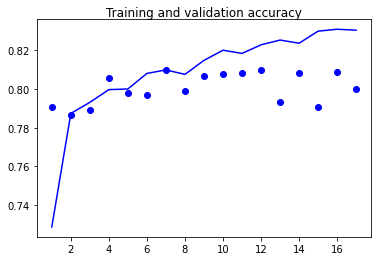

In [17]:
import matplotlib.pyplot as plt

#plot accurarancy of model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='train')
plt.plot(epochs, val_acc, 'bo', label='validation')
plt.title('Training and validation accuracy', pad=-50)
plt.show()

As can been observed the model achieve a higher score of **80.6** on the validation set.

**4.0 Prepare submission file**

Below code prepares the kaggle submission file.

In [18]:
def prepare_test_data(df):
    #prepare test data to input to model
    X_test = []

    #process the tweets
    for tweet in df['text'].values:
        X_test.append(process_tweet(tweet))

    X_sequences = kr_tokenizer.texts_to_sequences(X_test)

    X_sequences = pad_sequences(X_sequences)
    
    return X_sequences

In [19]:
#process the test data
X_test = prepare_test_data(test_df)



In [20]:
pred1 = [int(round(p[0])) for p in model1.predict(X_test)]

In [21]:
#store the predictions in dataframe
df = pd.DataFrame({'id': test_df['id'].to_list(), 'target': pred1})

#export to csv file
df.to_csv('submission.csv', index=False)

df


,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
